## Plot univariate correlation heatmaps for mutation prediction, across gene features

To support the idea of selecting features using cancer type specific $f$-statistics, we wanted to visualize $f$-statistics across cancer types for some genes. We are expecting to see that when we select by MAD or pan-cancer $f$-statistic we often get genes/features that are highly correlated with the label in one cancer type and not in others, but when we select by median $f$-statistic we find features that are more evenly correlated across all cancer types in the dataset, relative to the other methods.

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au
import pancancer_evaluation.utilities.data_utilities as du

%load_ext autoreload
%autoreload 2

### Load data

In [2]:
# gene to analyze features for
gene = 'PTEN'

# plot parameters
# calculate f-statistics from this number of genes by MAD
num_mad_genes = 10000

# plot this many genes on the x-axis of heatmaps
# (if this is too big heatmaps are hard to read)
num_genes_to_plot = 100

# where to save plots
output_plots = True
output_plots_dir = Path('./heatmaps')

In [3]:
print('Loading gene label data...', file=sys.stderr)
genes_df = du.load_top_50()
sample_info_df = du.load_sample_info(verbose=True)

# this returns a tuple of dataframes, unpack it below
pancancer_data = du.load_pancancer_data(verbose=True)
(sample_freeze_df,
 mutation_df,
 copy_loss_df,
 copy_gain_df,
 mut_burden_df) = pancancer_data

rnaseq_df = du.load_expression_data(verbose=True)

Loading gene label data...
Loading sample info...
Loading pan-cancer data from cached pickle file...
Loading gene expression data...


In [4]:
print(rnaseq_df.shape)
rnaseq_df.iloc[:5, :5]

(11060, 16148)


,1,10,100,1000,10000
sample_id,,,,,
TCGA-02-0047-01,125.0,10.40,136.0,2300.0,1300.0
TCGA-02-0055-01,392.0,1.12,222.0,1820.0,903.0
TCGA-02-2483-01,272.0,4.64,256.0,2890.0,1320.0
TCGA-02-2485-01,83.9,20.00,129.0,6970.0,10100.0
TCGA-02-2486-01,108.0,3.66,205.0,2250.0,873.0


In [5]:
y_df = (mutation_df
    .loc[:, [gene]]
    .merge(sample_freeze_df, left_index=True, right_on='SAMPLE_BARCODE')
    .drop(columns='PATIENT_BARCODE')
    .set_index('SAMPLE_BARCODE')
    .rename(columns={gene: 'status',
                     'DISEASE': 'cancer_type',
                     'SUBTYPE': 'subtype'})
)
display(y_df.shape, y_df.head())

(9074, 3)

,status,cancer_type,subtype
SAMPLE_BARCODE,,,
TCGA-02-0047-01,0,GBM,IDHwt
TCGA-02-0055-01,1,GBM,IDHwt
TCGA-02-2483-01,0,GBM,IDHmut-non-codel
TCGA-02-2485-01,0,GBM,IDHwt
TCGA-02-2486-01,0,GBM,IDHwt


In [6]:
X_df_unscaled = rnaseq_df.reindex(y_df.index)

X_df = pd.DataFrame(
    StandardScaler().fit_transform(X_df_unscaled),
    index=X_df_unscaled.index.copy(),
    columns=X_df_unscaled.columns.copy()
)

# make sure we didn't introduce any NA rows
assert X_df.isna().sum().sum() == 0

display(X_df.shape,
        X_df.isna().sum().sum(),
        X_df.iloc[:5, :5])

(9074, 16148)

0

,1,10,100,1000,10000
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,-0.134350,-0.115823,-0.208325,1.022045,0.645482
TCGA-02-0055-01,-0.112881,-0.216739,-0.139308,0.683152,0.164651
TCGA-02-2483-01,-0.122530,-0.178461,-0.112022,1.438602,0.669705
TCGA-02-2485-01,-0.137654,-0.011428,-0.213943,4.319199,11.303693
TCGA-02-2486-01,-0.135717,-0.189118,-0.152951,0.986744,0.128316


### Get distribution of univariate feature correlations

In [7]:
def filter_cancer_types(gene, X_df, y_df, sample_freeze_df, mutation_burden_df):
    # most of this code is copied from process_y_matrix in pancancer_utilities.tcga_utilities
    # 
    # note this is not including copy number variants, to do that we have to
    # know oncogene/TSG status for every gene (need to figure out where to get
    # this info)
    y_df = (
        y_df.merge(
            sample_freeze_df,
            how='left',
            left_index=True,
            right_on='SAMPLE_BARCODE'
        )
        .set_index('SAMPLE_BARCODE')
        .merge(mutation_burden_df, left_index=True, right_index=True)
    )
    disease_counts_df = pd.DataFrame(y_df.groupby('cancer_type').sum()['status'])
    disease_proportion_df = disease_counts_df.divide(
        y_df['cancer_type'].value_counts(sort=False).sort_index(), axis=0
    )
    filter_disease_df = (
        (disease_counts_df > cfg.filter_count) &
        (disease_proportion_df > cfg.filter_prop)
    )
    disease_proportion_df['disease_included'] = filter_disease_df
    disease_proportion_df['count'] = disease_counts_df['status']
    filter_disease_df.columns = ['disease_included']
    
    use_diseases = disease_proportion_df.query('disease_included').index.tolist()
    
    y_filtered_df = y_df.query('cancer_type in @use_diseases')
    X_filtered_df = X_df.reindex(index=y_filtered_df.index)
    
    return X_filtered_df, y_filtered_df

def get_f_stats_for_cancer_types(gene, X_df, y_df):
    # filter to cancer types with sufficient mutations
    X_filtered_df, y_filtered_df = filter_cancer_types(
        gene, X_df, y_df, sample_freeze_df, mut_burden_df
    )
    assert X_filtered_df.isna().sum().sum() == 0
    
    # then calculate pan-cancer and specific-cancer f-statistics
    # (i.e. univariate correlations with labels)
    f_stats_df = {
        'pancan': f_classif(X_filtered_df, y_filtered_df.status)[0]
    }
    for cancer_type in y_filtered_df.cancer_type.unique():
        ct_samples = y_filtered_df[y_filtered_df.cancer_type == cancer_type].index
        X_ct_df = X_filtered_df.reindex(ct_samples)
        y_ct_df = y_filtered_df.reindex(ct_samples)
        
        f_stats_df[cancer_type] = f_classif(X_ct_df, y_ct_df.status)[0]
        
    return pd.DataFrame(f_stats_df, index=X_filtered_df.columns)

In [8]:
X_filtered_df, y_filtered_df = filter_cancer_types(
    gene, X_df, y_df, sample_freeze_df, mut_burden_df
)
display(X_filtered_df.shape, X_filtered_df.iloc[:5, :5])

(3435, 16148)

,1,10,100,1000,10000
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,-0.134350,-0.115823,-0.208325,1.022045,0.645482
TCGA-02-0055-01,-0.112881,-0.216739,-0.139308,0.683152,0.164651
TCGA-02-2483-01,-0.122530,-0.178461,-0.112022,1.438602,0.669705
TCGA-02-2485-01,-0.137654,-0.011428,-0.213943,4.319199,11.303693
TCGA-02-2486-01,-0.135717,-0.189118,-0.152951,0.986744,0.128316


### Heatmaps

In [9]:
mad_genes = (X_filtered_df
    .mad(axis='index')
    .sort_values(ascending=False)
    .index
)[:num_mad_genes]

display(mad_genes.shape, mad_genes[:10])

(10000,)

Index(['27134', '7594', '55342', '8503', '253782', '91860', '9453', '10827',
       '27236', '7511'],
      dtype='object')

In [10]:
X_selected_df = X_df.loc[:, X_df.columns.intersection(mad_genes)]
f_stats_df = get_f_stats_for_cancer_types(gene, X_selected_df, y_df)
    
display(f_stats_df.shape, f_stats_df.iloc[:5, :5])

(10000, 9)

,pancan,GBM,LUSC,UCEC,CESC
1000,30.712748,1.346641e-03,0.077496,1.670082,0.071961
10000,60.521706,4.650903e-01,0.980724,0.094307,1.952221
10001,2.109735,3.217050e-01,2.886425,28.740988,0.212487
10005,9.575810,9.479898e-01,0.464582,10.191208,0.220327
10006,48.053270,1.947837e-07,0.767371,1.005452,1.393682


In [11]:
f_mad_df = (f_stats_df
  .dropna(axis='columns')
  .drop(columns=['pancan'])
  .loc[mad_genes[:num_genes_to_plot], :]
)

sorted_genes = f_mad_df.median(axis='columns').sort_values(ascending=False).index
f_mad_df = f_mad_df.reindex(sorted_genes)
sorted_cancer_types = f_mad_df.median(axis='index').sort_values(ascending=False).index
f_mad_df = f_mad_df.reindex(columns=sorted_cancer_types)

display(f_mad_df.shape, f_mad_df.iloc[:5, :5])

(100, 8)

,UCEC,CESC,STAD,COAD,BRCA
5229,30.797374,13.561963,16.686732,6.102086,4.399909
8503,85.110544,15.165847,4.998322,1.193976,4.730130
8452,20.649365,13.436651,0.190589,3.019774,6.086905
2065,33.711400,0.240895,3.812066,5.361484,3.688899
6726,13.858516,11.360587,3.020936,0.381738,3.327115


<AxesSubplot:>

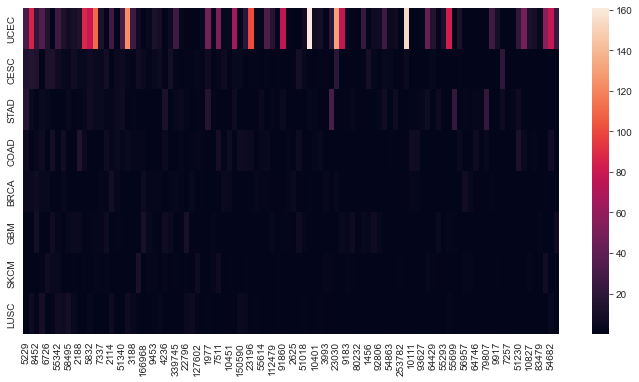

In [12]:
sns.set({'figure.figsize': (12, 6)})

max_mad_value = f_mad_df.max().max()
sns.heatmap(f_mad_df.T)

In [13]:
pancan_genes = f_stats_df.pancan.sort_values(ascending=False).index
display(pancan_genes.shape, pancan_genes[:10])

(10000,)

Index(['80150', '64321', '53407', '10251', '1750', '1749', '29091', '168002',
       '25776', '84281'],
      dtype='object')

In [14]:
f_pancan_df = (f_stats_df
  .dropna(axis='columns')
  .drop(columns=['pancan'])
  .loc[pancan_genes[:num_genes_to_plot], :]
)

sorted_genes = f_pancan_df.median(axis='columns').sort_values(ascending=False).index
f_pancan_df = f_pancan_df.reindex(sorted_genes).reindex(columns=sorted_cancer_types)

display(f_pancan_df.shape, f_pancan_df.iloc[:5, :5])

(100, 8)

,UCEC,CESC,STAD,COAD,BRCA
25864,12.964354,6.726707,2.296072,8.889213,2.136359
10251,51.348697,0.366850,5.991707,8.877541,1.729005
6001,12.692112,1.100509,3.248870,6.848143,0.064522
55135,12.254324,1.523795,4.549632,12.155181,0.117446
25854,56.093083,3.797107,0.930757,3.951083,1.654215


<AxesSubplot:>

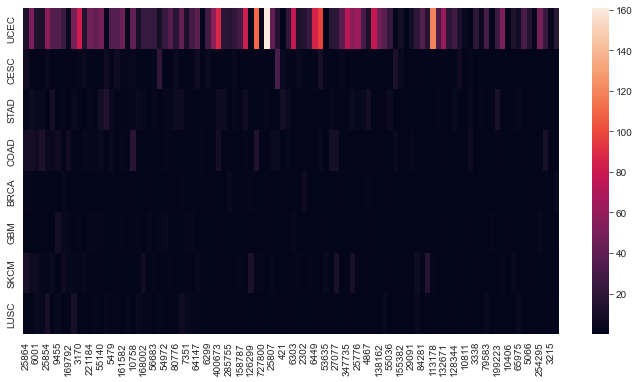

In [15]:
sns.set({'figure.figsize': (12, 6)})

f_pancan_df.where(f_pancan_df <= max_mad_value, max_mad_value, inplace=True)
sns.heatmap(f_pancan_df.T)

In [16]:
median_genes = (f_stats_df
  .drop(columns=['pancan'])
  .median(axis='columns')
  .sort_values(ascending=False)
  .index
)
display(median_genes.shape, median_genes[:10])

(10000,)

Index(['60528', '2872', '126308', '54836', '55251', '30001', '27245', '55255',
       '57405', '10014'],
      dtype='object')

In [17]:
f_median_df = (f_stats_df
  .dropna(axis='columns')
  .drop(columns=['pancan'])
  .loc[median_genes[:num_genes_to_plot], :]
)

sorted_genes = f_median_df.median(axis='columns').sort_values(ascending=False).index
f_median_df = f_median_df.reindex(sorted_genes).reindex(columns=sorted_cancer_types)

display(f_median_df.shape, f_median_df.iloc[:5, :5])

(100, 8)

,UCEC,CESC,STAD,COAD,BRCA
60528,20.489800,9.870274,13.516405,9.084276,0.065692
2872,103.177151,13.888587,10.045344,1.771473,6.283088
126308,90.261170,0.002124,8.890955,6.892435,10.445159
54836,64.296128,13.435696,2.633112,7.541723,0.307509
55251,39.808450,4.306524,9.930459,18.524199,1.319150


<AxesSubplot:>

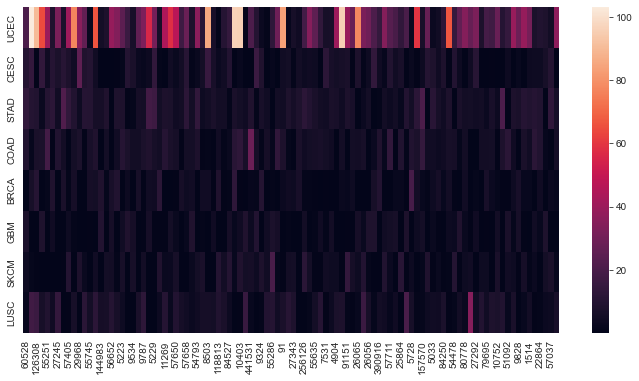

In [18]:
sns.set({'figure.figsize': (12, 6)})

f_median_df.where(f_median_df <= max_mad_value, max_mad_value, inplace=True)
sns.heatmap(f_median_df.T)

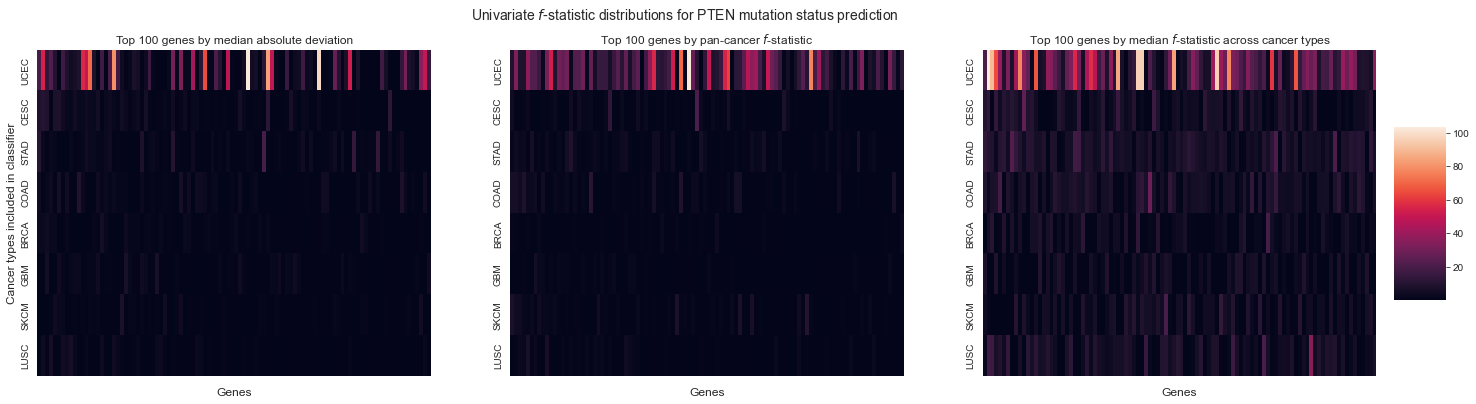

In [19]:
sns.set({'figure.figsize': (24, 6)})

fig, axarr = plt.subplots(1, 3)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

sns.heatmap(f_mad_df.T, ax=axarr[0], cbar=False)
axarr[0].set_title('Top {} genes by median absolute deviation'.format(num_genes_to_plot))
axarr[0].set_xticklabels([])
axarr[0].set_xlabel('Genes', size=12)
axarr[0].set_ylabel('Cancer types included in classifier', size=12)

sns.heatmap(f_pancan_df.T, ax=axarr[1], cbar=False)
axarr[1].set_title(r'Top {} genes by pan-cancer $f$-statistic'.format(num_genes_to_plot))
axarr[1].set_xticklabels([])
axarr[1].set_xlabel('Genes', size=12)

sns.heatmap(f_median_df.T, ax=axarr[2], cbar_ax=cbar_ax)
axarr[2].set_title(r'Top {} genes by median $f$-statistic across cancer types'.format(num_genes_to_plot))
axarr[2].set_xticklabels([])
axarr[2].set_xlabel('Genes', size=12)

plt.suptitle(r'Univariate $f$-statistic distributions for {} mutation status prediction'.format(gene), size=14)

if output_plots:
    output_plots_dir.mkdir(exist_ok=True)
    plt.savefig(output_plots_dir / '{}_heatmaps.png'.format(gene),
                dpi=200, bbox_inches='tight')

For _PTEN_ above we can definitely see the expected trend - in the left and middle heatmaps we see that most genes have low correlations/$f$-statistics in most cancer types, but in the right heatmap we can see that the $f$-statistics are more evenly distributed across cancer types (although still largely dominated by correlations in UCEC, where _PTEN_ is frequently mutated and is thought to have a strong driver effect).